L'obiettivo del progetto è creare un classificatore basato sui dati MALDI (macro-gruppo 3) che possa predire la sottospecie di Streptococcus (colonna H) e l'antibiotico-sensibilità (macro-gruppi 4 e 5).
Qualora i dati MALDI non fossero sufficienti per la classificazione, sarebbe possibile inserire nel modello anche le informazioni delle colonne D, I e J.
Infine altre informazioni che sarebbe interessante poter predire sono i sequence type (ST- colonna F) ed i fattori di virulenza (macro-gruppo 6).
 
Come vedrai, i dati sono organizzati in sei macro-gruppi:
 
     1. Metadati origine isolati. Si tratta di informazioni relative all'anno, la regione, la specie animale e l'organo di provenienza dell'isolato. La colonna ID Strain rappresenta l'identificativo di ogni isolato di Streptoccus e quindi è quella che ci consente di rintracciare le informazioni.
 
     2. Informazioni principali isolati. Sono riportati i dati principali di ogni isolato in termini microbiologici. La colonna H è quella più importante per la finalità del progetto: avremmo bisogno di poter predire la sottospecie a cui appartiene ciascun isolato. L'identificazione che trovi alla colonna H è stata ottenuta tramite genomica e rappresenta il valore di riferimento. Un'altra colonna che ci piacerebbe poter predire è la colonna F. Questa colonna rappresenta gli ST, identificativi genomici di un ceppo batterico. Le colonne I e J (lancefield group e haemolysis) sono dati che possono essere integrati nel classificatore per predire la colonna H.
 
     3. Picchi MALDI m/z individuati e loro intensità. Sono i dati principali da utilizzare nel classificatore, derivanti dai test in MALDI-TOF. Nelle colonne sono descritti i picchi m/z (massa/carica). I valori rappresentano l'intensità di ciascun picco relativamente ad un campione.
 
     4. Sensibilità agli antibiotici (S: sensibile; NS: non sensibile). Sono i dati relativi alla sensibilità agli antibiotici. Sarebbe interessante verificare se il classificatore basato sui picchi MALDI riesca a predire la sensibilità agli antibiotici.
 
     5. Geni di antibiotico-resistenza. Presenza (1) o assenza (0) di geni di resistenza per gli antibiotici. Sarebbe interessante verificare se il classificatore basato sui picchi MALDI riesca a predire la presenza di questi geni, i dati potrebbero esser simili a quelli del punto 4.
 
     6. Fattori di virulenza. Presenza (1) o assenza (0) di fattori di virulenza. Si potrebbe verificare se si possano predire dai picchi MALDI.

In [1]:
# pandas -> read input file and data manipulation
import pandas as pd

# numpy -> array manipulations
import numpy as np

# pandas, matplotlib & seaborn -> plotting
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import parallel_coordinates

# sklearn -> data processing, models fit, make predictions and analyze the results
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
from sklearn.tree import export_text
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.metrics import accuracy_score 
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.datasets import fetch_openml
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.decomposition import PCA


# custom functions
from src.visualization import categorical_count_plot
from src.visualization import feature_importances_plot
from src.visualization import regression_diagnostic_plot

# warnings -> to silence warnings
import warnings
warnings.filterwarnings("ignore")

/opt/conda/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


In [2]:
df = pd.read_csv("data/Dati_Matemaldomics_corretto.csv",delimiter=';',index_col='ID Strain')
df

,Year,Region,Animal species of origin,Organ of origin,ST,Species,Putative Subspecies,LANCEFIELD GROUP,Haemolysis,"2021,944237",...,scpA,sda,ska,slo,smeZ,spec,speg,spek,spel,spem
ID Strain,,,,,,,,,,,,,,,,,,,,,
V13,ante 2004,NaN,Dog,Urine,ST13,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V142,2008,NaN,Dog,Urine,ST23,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V151,2008,NaN,Dog,Ear,ST95,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V160,2011,NaN,Dog,Skin,ST15,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V161,2011,NaN,Cat,Lung,ST9,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,2021,NaN,Bovine,Milk,ST307,Streptococcus_dysgalactiae,Streptococcus dysgalactiae subsp. dysgalactiae,C,a,"5,57269E-05",...,0,1,0,0,0,0,0,0,0,0
V82,2006,NaN,Cat,Intestine,ST9,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V90,2006,NaN,Dog,Pus,ST13,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0


In [3]:
# load dataset
metadati = df[['Year','Region','Animal species of origin','Organ of origin']]
principali = df[['ST','Species','Putative Subspecies','LANCEFIELD GROUP','Haemolysis']]
maldi = df[df.columns[11:315]]
antibiotici = df[df.columns[316:351]]
geni_antibiotico = df[df.columns[352:369]]

print(principali.shape)
print(maldi.shape)
print(antibiotici.shape)
print(geni_antibiotico.shape)
df.head(10)

(154, 5)
(154, 304)
(154, 35)
(154, 17)


,Year,Region,Animal species of origin,Organ of origin,ST,Species,Putative Subspecies,LANCEFIELD GROUP,Haemolysis,"2021,944237",...,scpA,sda,ska,slo,smeZ,spec,speg,spek,spel,spem
ID Strain,,,,,,,,,,,,,,,,,,,,,
V13,ante 2004,NaN,Dog,Urine,ST13,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V142,2008,NaN,Dog,Urine,ST23,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V151,2008,NaN,Dog,Ear,ST95,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V160,2011,NaN,Dog,Skin,ST15,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V161,2011,NaN,Cat,Lung,ST9,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V175,2018,NaN,Dog,Septicemia,ST13,Streptococcus_dysgalactiae,Streptococcus dysgalactiae subsp. equisimilis,C,b,NaN,...,0,0,0,0,0,0,1,0,0,0
V186,2019,NaN,Dog,Ear,ST9,Streptococcus_canis,Streptococcus canis,G,b,NaN,...,0,0,0,0,0,0,0,0,0,0
V188,2019,NaN,Dog,Intestine,ST240,Streptococcus_dysgalactiae,Streptococcus dysgalactiae subsp. equisimilis,A,b,"4,40964E-05",...,0,0,0,0,0,0,1,0,0,0
V190,2019,Lazio,Bovine,Milk,ST706,Streptococcus_dysgalactiae,Streptococcus dysgalactiae subsp. dysgalactiae,C,a,"5,38515E-05",...,0,0,0,0,0,0,0,0,0,1


In [4]:
df.shape

(154, 369)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 154 entries, V13 to V95
Columns: 369 entries, Year to spem
dtypes: int64(45), object(324)
memory usage: 445.2+ KB


# Analisi metadati

In [6]:
#Dato che non si può convertire ante 2004 in intero lo sostituisco con 2003 anche se non considera solo il 2003 ma tutti gli anni prima
metadati = metadati.replace('ante 2004','2003')
metadati['Year']=pd.to_numeric(metadati['Year'])
metadati['target'] = principali["Putative Subspecies"]

In [7]:
metadati.sample(10)

,Year,Region,Animal species of origin,Organ of origin,target
ID Strain,,,,,
V160,2011,NaN,Dog,Skin,Streptococcus canis
V79,2005,NaN,Cat,Liver,Streptococcus canis
V729,2014,Veneto,Bovine,Milk,Streptococcus dysgalactiae subsp. dysgalactiae
V577,2020,Lombardia,Bovine,Milk,Streptococcus dysgalactiae subsp. dysgalactiae
V190,2019,Lazio,Bovine,Milk,Streptococcus dysgalactiae subsp. dysgalactiae
V790,2021,Lazio,Swine,Nose,Streptococcus dysgalactiae subsp. equisimilis
V43,2004,NaN,Dog,Vaginal swab,Streptococcus canis
V576,2020,Lazio,Bovine,Milk,Streptococcus dysgalactiae subsp. dysgalactiae
V738,2021,NaN,Cat,Pus,Streptococcus canis


In [8]:
metadati.isnull().sum()

Year                         0
Region                      65
Animal species of origin     0
Organ of origin              5
target                       0
dtype: int64

In [9]:
#sostituisce valori nulli sull'organo di origine con quello più frequente
organ_origin = metadati[["Organ of origin"]].values
si = SimpleImputer(strategy="most_frequent")
organ_origin_imputed = si.fit_transform(organ_origin)

<AxesSubplot: xlabel='Year', ylabel='count'>

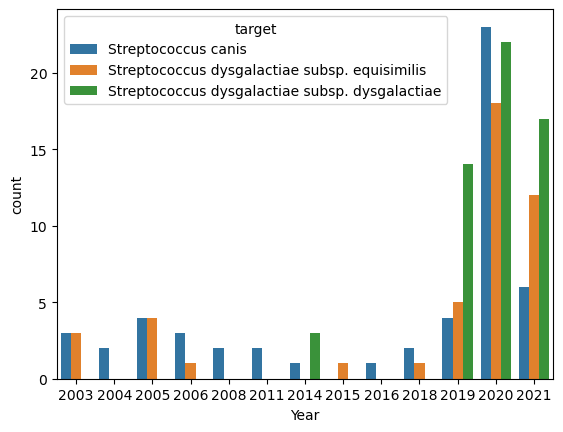

In [10]:
sns.countplot(x="Year", data=metadati, hue='target')

<AxesSubplot: xlabel='count', ylabel='Region'>

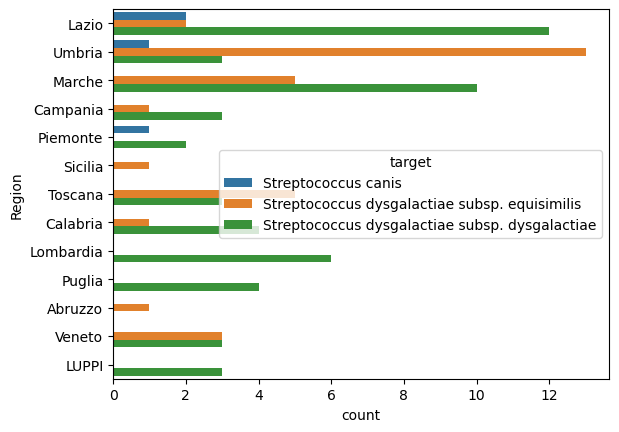

In [11]:
sns.countplot(y="Region", data=metadati, hue='target')

<AxesSubplot: xlabel='count', ylabel='Animal species of origin'>

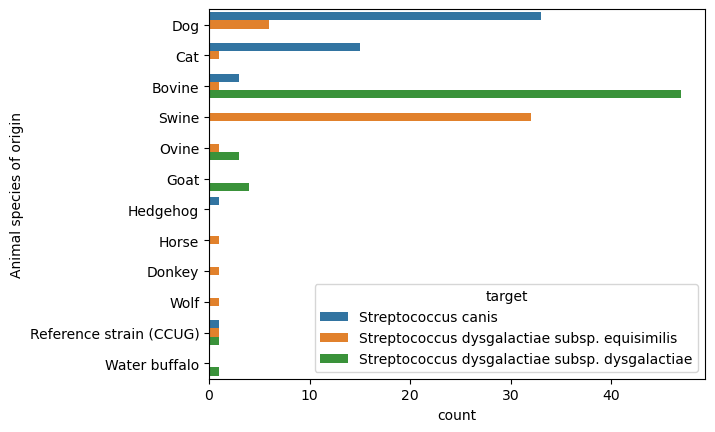

In [12]:
sns.countplot(y="Animal species of origin", data=metadati, hue='target')

<AxesSubplot: xlabel='count', ylabel='Organ of origin'>

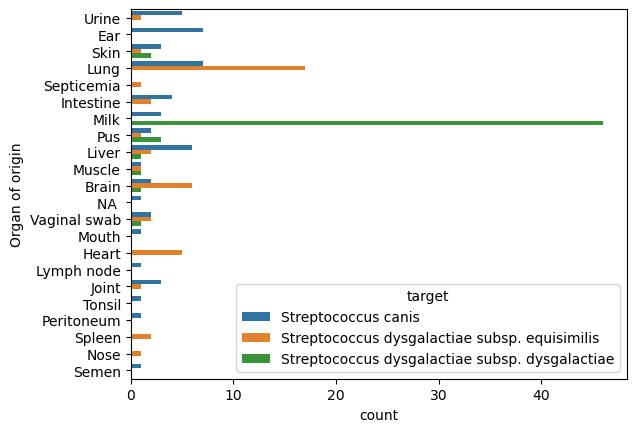

In [13]:
sns.countplot(y="Organ of origin", data=metadati, hue='target')

In [14]:
X_train, X_test, y_train, y_test = train_test_split(metadati.drop(columns='target'), df['Putative Subspecies'], test_size=0.2, random_state=42, stratify=df['Putative Subspecies'])
metadati['target']
y_train

ID Strain
V195                               Streptococcus canis
V536     Streptococcus dysgalactiae subsp. equisimilis
V632    Streptococcus dysgalactiae subsp. dysgalactiae
V8                                 Streptococcus canis
V745    Streptococcus dysgalactiae subsp. dysgalactiae
                             ...                      
V689    Streptococcus dysgalactiae subsp. dysgalactiae
V544                               Streptococcus canis
V637     Streptococcus dysgalactiae subsp. equisimilis
V305     Streptococcus dysgalactiae subsp. equisimilis
V210                               Streptococcus canis
Name: Putative Subspecies, Length: 123, dtype: object

In [15]:
#One-Hot encode delle variabili categoriche
metadati_X = ['Region','Animal species of origin','Organ of origin']
ct_meta = ColumnTransformer(transformers=[
    ("OneHot", OneHotEncoder(drop="if_binary", sparse=False, dtype=int), metadati_X)
],remainder="passthrough")

metadati_arr = ct_meta.fit_transform(X=X_train)
metadati_enc = pd.DataFrame(data=metadati_arr, columns=ct_meta.get_feature_names_out())
metadati_enc['target'] = y_train
metadati_enc

,OneHot__Region_Abruzzo,OneHot__Region_Calabria,OneHot__Region_Campania,OneHot__Region_LUPPI,OneHot__Region_Lazio,OneHot__Region_Lombardia,OneHot__Region_Marche,OneHot__Region_Piemonte,OneHot__Region_Puglia,OneHot__Region_Toscana,...,OneHot__Organ of origin_Semen,OneHot__Organ of origin_Septicemia,OneHot__Organ of origin_Skin,OneHot__Organ of origin_Spleen,OneHot__Organ of origin_Tonsil,OneHot__Organ of origin_Urine,OneHot__Organ of origin_Vaginal swab,OneHot__Organ of origin_nan,remainder__Year,target
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2016,NaN
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2020,NaN
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,2021,NaN
3,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,2003,NaN
4,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,2021,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2021,NaN
119,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,2020,NaN
120,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2021,NaN
121,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2020,NaN


In [16]:
#TO DO:Modelli con colonne metadati codificate

# Analisi Principali

In [17]:
principali.dtypes

ST                     object
Species                object
Putative Subspecies    object
LANCEFIELD GROUP       object
Haemolysis             object
dtype: object

In [18]:
principali

,ST,Species,Putative Subspecies,LANCEFIELD GROUP,Haemolysis
ID Strain,,,,,
V13,ST13,Streptococcus_canis,Streptococcus canis,G,b
V142,ST23,Streptococcus_canis,Streptococcus canis,G,b
V151,ST95,Streptococcus_canis,Streptococcus canis,G,b
V160,ST15,Streptococcus_canis,Streptococcus canis,G,b
V161,ST9,Streptococcus_canis,Streptococcus canis,G,b
...,...,...,...,...,...
V800,ST307,Streptococcus_dysgalactiae,Streptococcus dysgalactiae subsp. dysgalactiae,C,a
V82,ST9,Streptococcus_canis,Streptococcus canis,G,b
V90,ST13,Streptococcus_canis,Streptococcus canis,G,b


In [19]:
principali.isnull().sum()

ST                     0
Species                0
Putative Subspecies    0
LANCEFIELD GROUP       0
Haemolysis             0
dtype: int64

<AxesSubplot: xlabel='Count', ylabel='Putative Subspecies'>

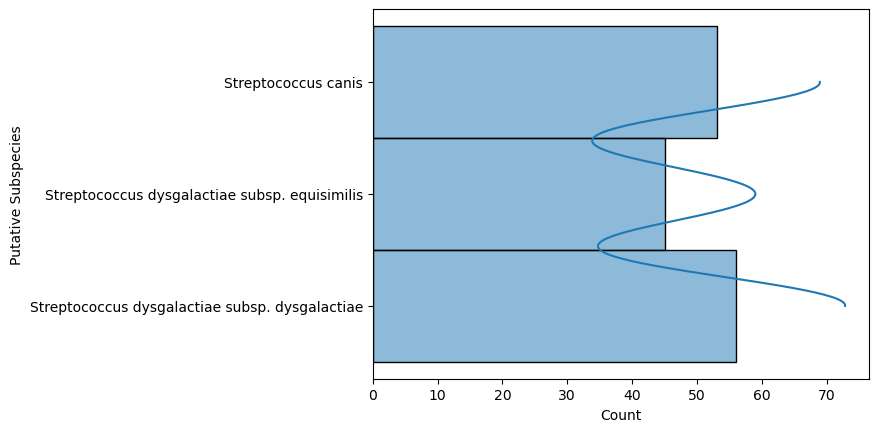

In [20]:
sns.histplot(data=principali, y="Putative Subspecies", kde=True)

In [21]:
#sns.countplot(y="Putative Subspecies", data=principali)

<AxesSubplot: xlabel='count', ylabel='Species'>

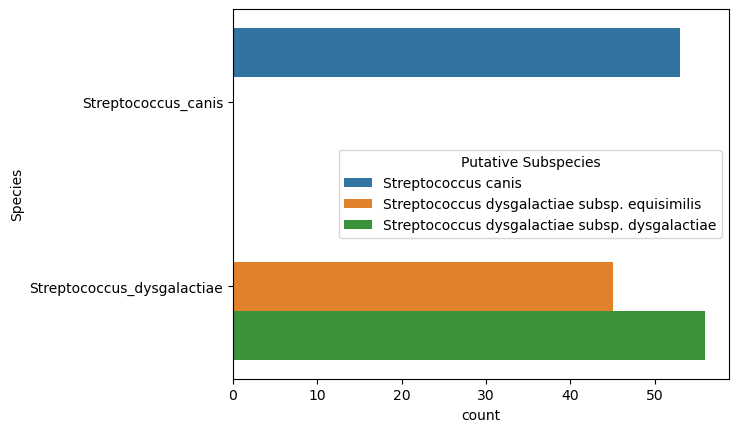

In [22]:
sns.countplot(y="Species", data=principali, hue="Putative Subspecies")

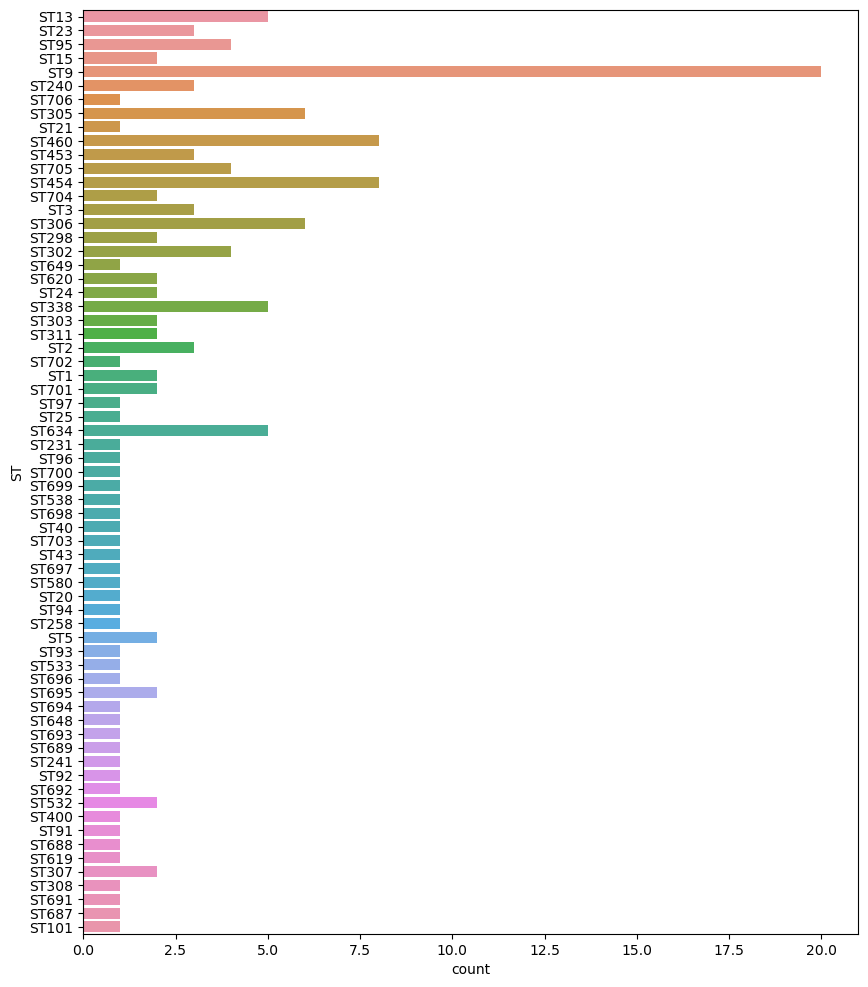

In [23]:
fig = plt.figure(figsize=(10, 12))
sns.countplot(y="ST", data=principali)
plt.show()

<AxesSubplot: xlabel='count', ylabel='LANCEFIELD GROUP'>

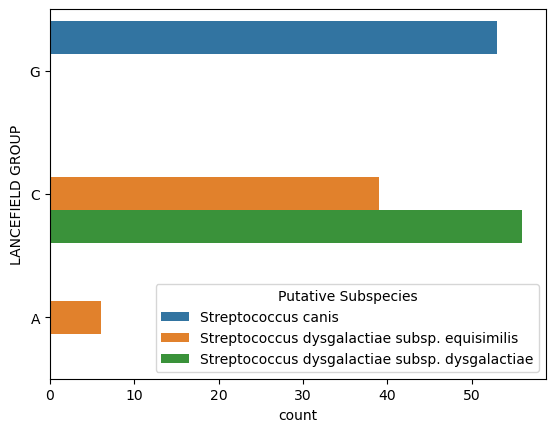

In [24]:
sns.countplot(y="LANCEFIELD GROUP", data=principali, hue="Putative Subspecies")

<AxesSubplot: xlabel='count', ylabel='Haemolysis'>

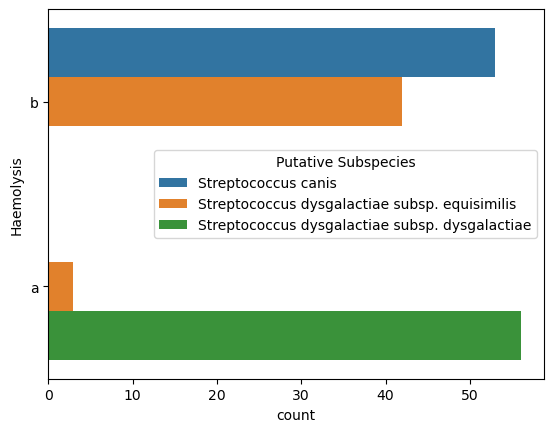

In [25]:
principali = principali.replace('b ','b')
sns.countplot(y="Haemolysis", data=principali, hue="Putative Subspecies")

In [26]:
principali["Species"].unique()

array(['Streptococcus_canis', 'Streptococcus_dysgalactiae'], dtype=object)

In [27]:
principali_X = ["Species", "Haemolysis", "LANCEFIELD GROUP"]
ct_princ = ColumnTransformer(transformers=[
    ("OneHot", OneHotEncoder(drop="first", sparse=False, dtype=int), principali_X)
],remainder="passthrough")

principali_arr = ct_princ.fit_transform(X=principali[principali_X])
principali_enc = pd.DataFrame(data=principali_arr, columns=ct_princ.get_feature_names_out())
principali_enc

,OneHot__Species_Streptococcus_dysgalactiae,OneHot__Haemolysis_b,OneHot__LANCEFIELD GROUP_C,OneHot__LANCEFIELD GROUP_G
0,0,1,0,1
1,0,1,0,1
2,0,1,0,1
3,0,1,0,1
4,0,1,0,1
...,...,...,...,...
149,1,0,1,0
150,0,1,0,1
151,0,1,0,1
152,0,1,0,1


# Analisi Picchi Maldi

In [28]:
maldi

,"2057,143278","2064,798679","2071,138797","2085,647901","2103,986922","2117,879078","2129,309534","2143,905333","2173,98153","2188,116404",...,"13617,65054","14104,26499","14945,23828","15048,68998","15154,39575","15353,52046","15399,07159","15495,16655","16076,29338","16202,09535"
ID Strain,,,,,,,,,,,,,,,,,,,,,
V13,"7,98659E-05",NaN,NaN,NaN,"8,6366E-05",NaN,"5,18954E-05","4,71446E-05","6,79758E-05","4,98065E-05",...,NaN,NaN,"6,6474E-05","0,000142108",NaN,NaN,NaN,NaN,NaN,NaN
V142,NaN,NaN,"4,95094E-05","4,4623E-05","7,7739E-05",NaN,"4,71991E-05",NaN,"9,10179E-05",NaN,...,NaN,NaN,"8,50988E-05","0,000194467",NaN,NaN,NaN,NaN,NaN,NaN
V151,NaN,NaN,"6,02675E-05","4,77862E-05","0,000100212",NaN,NaN,"4,66259E-05","5,38334E-05","5,36443E-05",...,NaN,NaN,"9,21027E-05","6,97349E-05",NaN,NaN,NaN,NaN,NaN,NaN
V160,NaN,NaN,"6,55556E-05",NaN,"8,85014E-05",NaN,"5,06035E-05",NaN,"6,73724E-05",NaN,...,NaN,NaN,"9,8051E-05","0,000135981",NaN,NaN,NaN,NaN,NaN,NaN
V161,NaN,NaN,NaN,NaN,"7,72199E-05",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"8,86343E-05","0,000203245",NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,"5,54677E-05",NaN,NaN,"6,04758E-05","0,000104711",NaN,NaN,NaN,"0,000117229",NaN,...,NaN,"3,59969E-05","7,29765E-05","5,96036E-05",NaN,NaN,NaN,NaN,NaN,NaN
V82,"4,27382E-05",NaN,NaN,NaN,"6,63897E-05",NaN,NaN,NaN,"5,30903E-05","4,95847E-05",...,NaN,NaN,"8,98385E-05","0,000143522",NaN,NaN,NaN,NaN,NaN,NaN
V90,NaN,NaN,"5,06192E-05",NaN,"8,87478E-05",NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,"0,000103564","0,000137316",NaN,NaN,"5,13985E-05",NaN,NaN,NaN


In [29]:
maldi.isnull().sum().sort_values(ascending=False).head(20)

5780,539599    140
6587,606933    139
2423,645677    138
2535,074449    138
6814,418663    138
5283,615576    138
3406,307673    138
5114,565557    138
2392,41521     138
4877,931808    138
9652,709405    138
2249,262227    137
15353,52046    137
5296,883734    136
6861,319414    136
2490,961213    136
5639,896531    136
3061,280788    136
4142,664282    136
15495,16655    136
dtype: int64

In [30]:
#sostituisco tutti i NaN con 0
maldi.fillna(0,inplace=True)

##### Preparazione dati maldi

In [31]:
maldi = maldi.replace(',', '.', regex=True)
maldi

,"2057,143278","2064,798679","2071,138797","2085,647901","2103,986922","2117,879078","2129,309534","2143,905333","2173,98153","2188,116404",...,"13617,65054","14104,26499","14945,23828","15048,68998","15154,39575","15353,52046","15399,07159","15495,16655","16076,29338","16202,09535"
ID Strain,,,,,,,,,,,,,,,,,,,,,
V13,7.98659E-05,0,0,0,8.6366E-05,0,5.18954E-05,4.71446E-05,6.79758E-05,4.98065E-05,...,0,0,6.6474E-05,0.000142108,0,0,0,0,0,0
V142,0,0,4.95094E-05,4.4623E-05,7.7739E-05,0,4.71991E-05,0,9.10179E-05,0,...,0,0,8.50988E-05,0.000194467,0,0,0,0,0,0
V151,0,0,6.02675E-05,4.77862E-05,0.000100212,0,0,4.66259E-05,5.38334E-05,5.36443E-05,...,0,0,9.21027E-05,6.97349E-05,0,0,0,0,0,0
V160,0,0,6.55556E-05,0,8.85014E-05,0,5.06035E-05,0,6.73724E-05,0,...,0,0,9.8051E-05,0.000135981,0,0,0,0,0,0
V161,0,0,0,0,7.72199E-05,0,0,0,0,0,...,0,0,8.86343E-05,0.000203245,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,5.54677E-05,0,0,6.04758E-05,0.000104711,0,0,0,0.000117229,0,...,0,3.59969E-05,7.29765E-05,5.96036E-05,0,0,0,0,0,0
V82,4.27382E-05,0,0,0,6.63897E-05,0,0,0,5.30903E-05,4.95847E-05,...,0,0,8.98385E-05,0.000143522,0,0,0,0,0,0
V90,0,0,5.06192E-05,0,8.87478E-05,0,0,0,0,0,...,0,0,0.000103564,0.000137316,0,0,5.13985E-05,0,0,0


In [32]:
columns = maldi.columns
for column in columns:
    maldi[column] = maldi[column].astype(float)
maldi

,"2057,143278","2064,798679","2071,138797","2085,647901","2103,986922","2117,879078","2129,309534","2143,905333","2173,98153","2188,116404",...,"13617,65054","14104,26499","14945,23828","15048,68998","15154,39575","15353,52046","15399,07159","15495,16655","16076,29338","16202,09535"
ID Strain,,,,,,,,,,,,,,,,,,,,,
V13,0.000080,0.0,0.000000,0.000000,0.000086,0.000000,0.000052,0.000047,0.000068,0.000050,...,0.0,0.000000,0.000066,0.000142,0.0,0.0,0.000000,0.0,0.0,0.0
V142,0.000000,0.0,0.000050,0.000045,0.000078,0.000000,0.000047,0.000000,0.000091,0.000000,...,0.0,0.000000,0.000085,0.000194,0.0,0.0,0.000000,0.0,0.0,0.0
V151,0.000000,0.0,0.000060,0.000048,0.000100,0.000000,0.000000,0.000047,0.000054,0.000054,...,0.0,0.000000,0.000092,0.000070,0.0,0.0,0.000000,0.0,0.0,0.0
V160,0.000000,0.0,0.000066,0.000000,0.000089,0.000000,0.000051,0.000000,0.000067,0.000000,...,0.0,0.000000,0.000098,0.000136,0.0,0.0,0.000000,0.0,0.0,0.0
V161,0.000000,0.0,0.000000,0.000000,0.000077,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000089,0.000203,0.0,0.0,0.000000,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,0.000055,0.0,0.000000,0.000060,0.000105,0.000000,0.000000,0.000000,0.000117,0.000000,...,0.0,0.000036,0.000073,0.000060,0.0,0.0,0.000000,0.0,0.0,0.0
V82,0.000043,0.0,0.000000,0.000000,0.000066,0.000000,0.000000,0.000000,0.000053,0.000050,...,0.0,0.000000,0.000090,0.000144,0.0,0.0,0.000000,0.0,0.0,0.0
V90,0.000000,0.0,0.000051,0.000000,0.000089,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.000000,0.000104,0.000137,0.0,0.0,0.000051,0.0,0.0,0.0


In [33]:
map_target = {
    "Streptococcus canis" : 0,
    "Streptococcus dysgalactiae subsp. equisimilis" : 1,
    "Streptococcus dysgalactiae subsp. dysgalactiae" : 2  
}
maldi['target'] = principali["Putative Subspecies"].map(map_target)
#sns.pairplot(data=maldi, hue='target')
maldi[['target']].sample(10)

,target
ID Strain,
V249,2
V785,2
V739,0
V151,0
V235,2
V200,2
V515,1
V56,1
V5,1


#### Ricerca correllazioni più alte con variabile target 

In [34]:
corr = maldi.corr()
corr

,"2057,143278","2064,798679","2071,138797","2085,647901","2103,986922","2117,879078","2129,309534","2143,905333","2173,98153","2188,116404",...,"14104,26499","14945,23828","15048,68998","15154,39575","15353,52046","15399,07159","15495,16655","16076,29338","16202,09535",target
"2057,143278",1.000000,-0.068457,-0.066517,0.493853,0.380472,-0.031394,0.185633,0.240985,0.473723,0.384678,...,-0.053156,-0.246925,0.113149,0.119611,0.219807,-0.236770,0.326854,-0.045185,-0.087578,-0.077452
"2064,798679",-0.068457,1.000000,-0.006892,0.068057,-0.042973,-0.041741,-0.034696,-0.037146,0.057989,-0.047709,...,-0.044438,0.030154,0.010930,0.104194,-0.026248,-0.041066,-0.029159,-0.040067,-0.044287,-0.001285
"2071,138797",-0.066517,-0.006892,1.000000,-0.065008,0.051752,-0.041721,-0.033553,-0.036940,-0.008164,-0.046862,...,0.202014,0.177975,0.047723,-0.034155,-0.026192,0.264887,-0.028286,-0.040026,-0.044241,-0.099858
"2085,647901",0.493853,0.068057,-0.065008,1.000000,0.349521,0.151131,0.036334,0.153132,0.401137,0.149272,...,0.041255,0.056237,-0.227843,-0.040405,-0.016386,-0.168047,0.023956,-0.256025,-0.289394,0.219587
"2103,986922",0.380472,-0.042973,0.051752,0.349521,1.000000,0.068998,0.238401,0.147754,0.650993,0.208672,...,0.009707,0.054503,-0.095421,-0.087589,0.036960,-0.111735,0.070743,-0.304763,-0.343140,-0.076477
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
"15399,07159",-0.236770,-0.041066,0.264887,-0.168047,-0.111735,0.010620,-0.166991,-0.145347,-0.184978,-0.184012,...,0.532930,0.410916,-0.134925,-0.082834,0.009880,1.000000,-0.182203,-0.155846,-0.000985,0.233494
"15495,16655",0.326854,-0.029159,-0.028286,0.023956,0.070743,-0.182219,-0.150355,-0.134466,0.029475,0.036742,...,-0.192708,-0.551438,0.661583,0.453883,0.449534,-0.182203,1.000000,0.334343,0.225451,-0.365778
"16076,29338",-0.045185,-0.040067,-0.040026,-0.256025,-0.304763,-0.251805,-0.207773,-0.183429,-0.139203,-0.128798,...,-0.197435,-0.528830,0.806979,0.323733,0.174298,-0.155846,0.334343,1.000000,0.863215,-0.373514
"16202,09535",-0.087578,-0.044287,-0.044241,-0.289394,-0.343140,-0.180800,-0.228891,-0.214990,-0.204771,-0.187413,...,-0.021207,-0.384607,0.652187,0.214881,0.083882,-0.000985,0.225451,0.863215,1.000000,-0.224832


In [35]:
corr = corr.sort_values('target')
top_corr_inv = corr[0:5]
top_corr = corr[-6:-1]
print(top_corr[['target']])
print(top_corr_inv[['target']])

               target
6731,019005  0.832741
6312,28957   0.834384
9829,326089  0.841308
6891,554249  0.844212
3364,797303  0.854254
               target
6327,306693 -0.875539
6710,334937 -0.745410
5522,688276 -0.710834
3762,662684 -0.703397
3354,28405  -0.695326


#### Pairplot 10 best correlation score

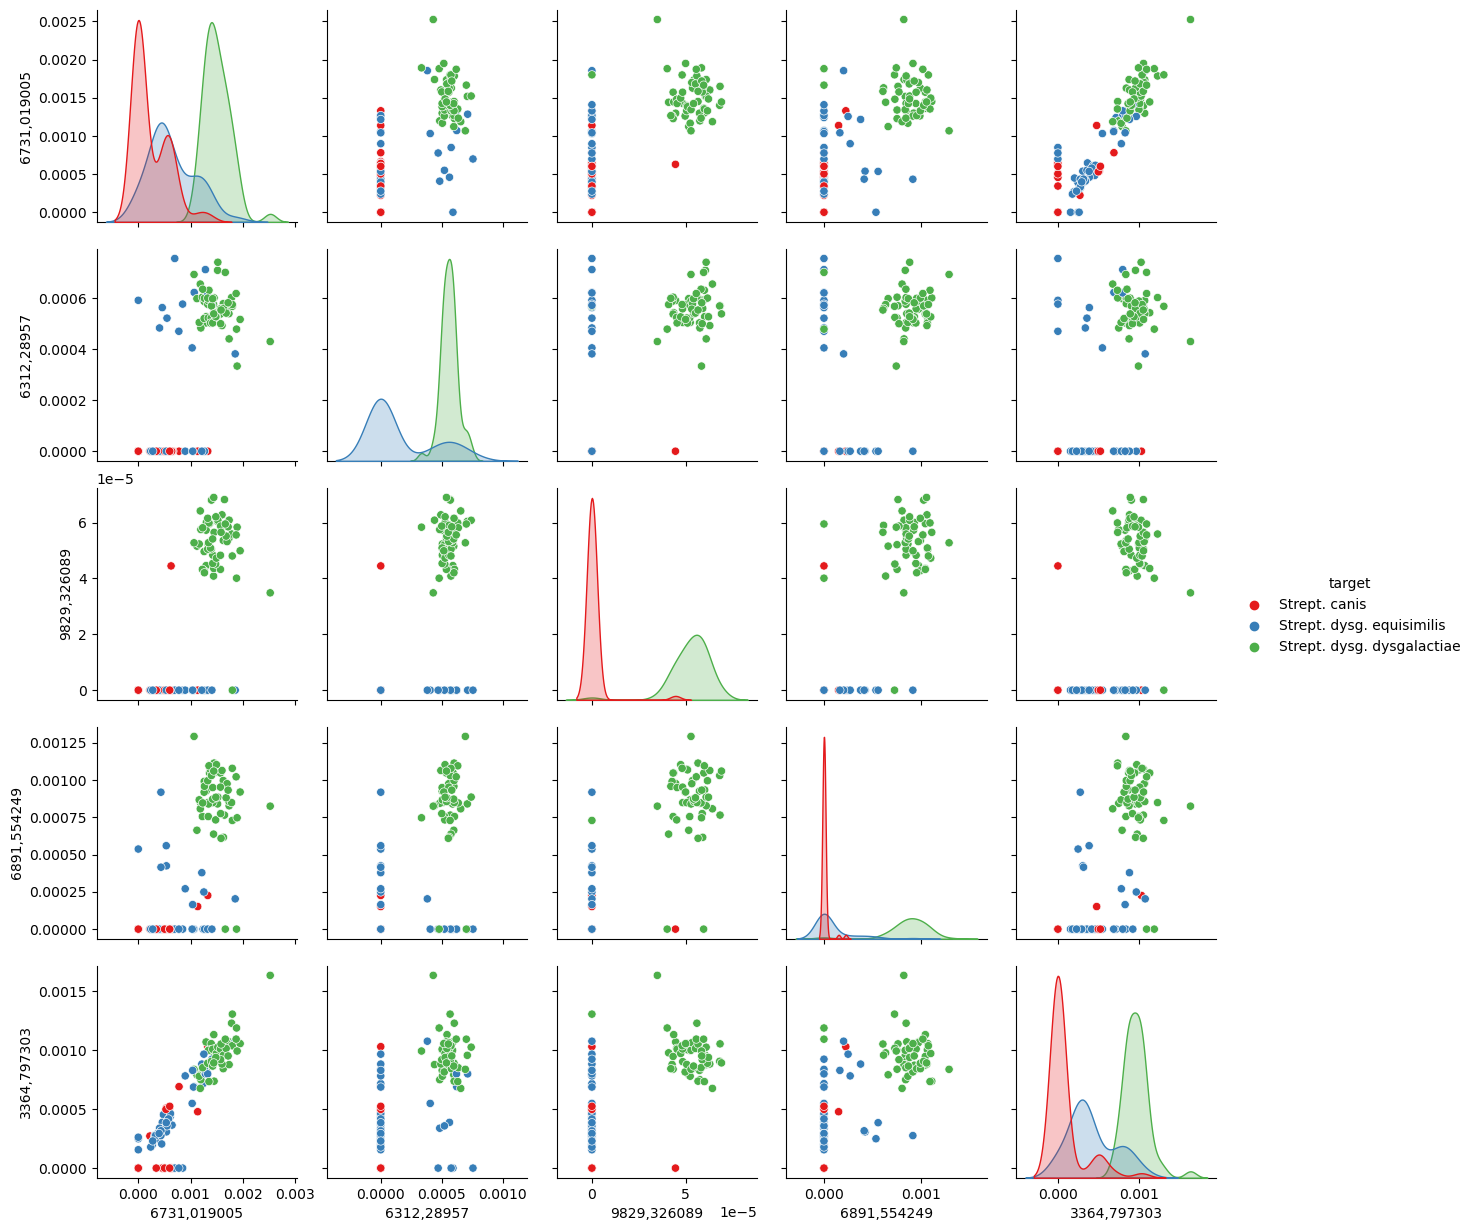

In [36]:
map_target_to_name = {
    0 : "Strept. canis",
    1 : "Strept. dysg. equisimilis",
    2 : "Strept. dysg. dysgalactiae"  
}
pairplot = maldi[top_corr.index.to_series()]
pairplot['target'] = maldi['target'].map(map_target_to_name)

sns.pairplot(data=pairplot, hue="target", palette=sns.color_palette('Set1'))
plt.show()

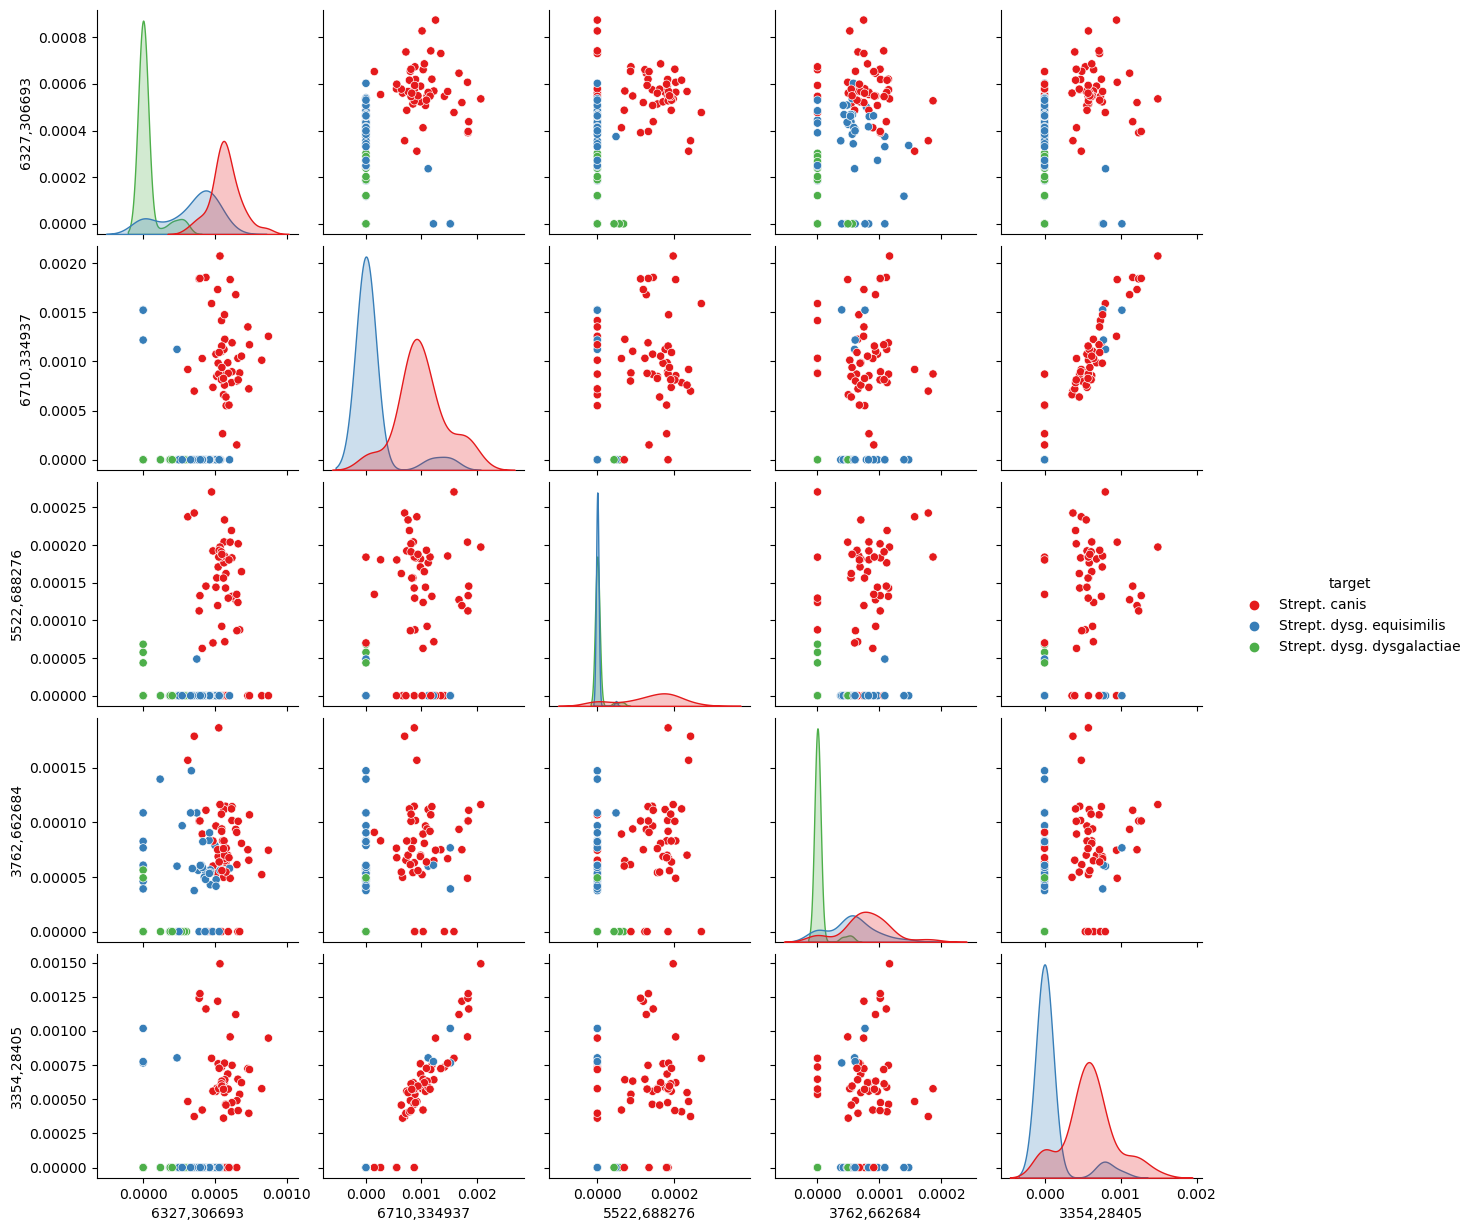

In [37]:
pairplot = maldi[top_corr_inv.index.to_series()]
pairplot['target'] = maldi['target'].map(map_target_to_name)
sns.pairplot(data=pairplot, hue="target", palette=sns.color_palette('Set1'))
plt.show()

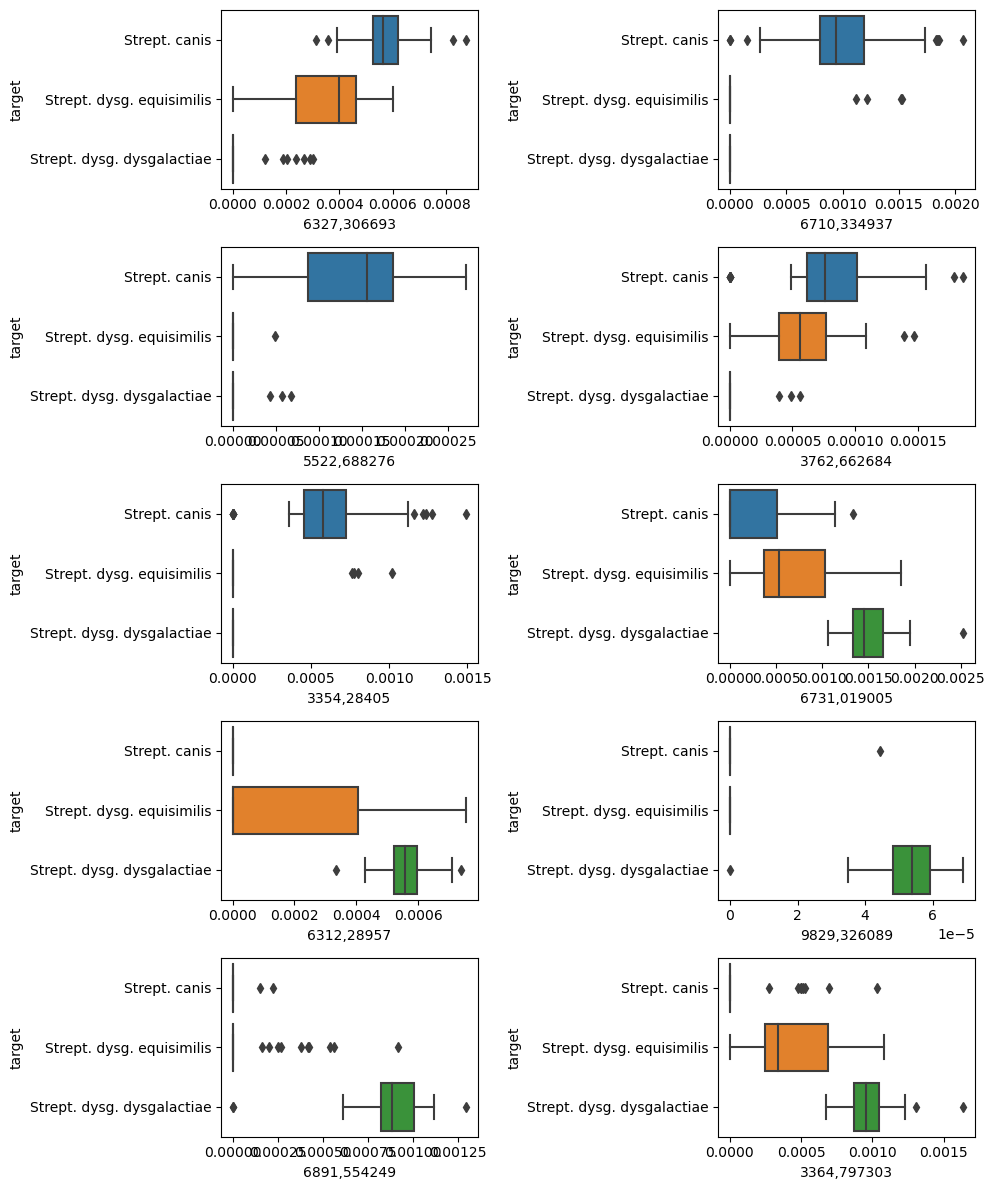

In [38]:
s1 = top_corr_inv.index
s2 = top_corr.index
boxplot_col = np.concatenate([s1, s2])
boxplot = maldi[boxplot_col]
boxplot['target'] = maldi['target'].map(map_target_to_name)
fig = plt.figure(figsize=(10, 12))
axes = fig.subplots(nrows=5, ncols=2)
for ax, column in zip(axes.flat, boxplot):
    sns.boxplot(y="target", x=column, data=boxplot, ax=ax)
plt.tight_layout()
plt.show()

### Training con 10 feature con correlazione più alta

In [39]:
index = pd.concat([top_corr.index.to_series(),top_corr_inv.index.to_series()])
X = maldi[index]
y = maldi['target']

In [40]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [41]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(123, 10)
(123,)
(31, 10)
(31,)


In [42]:
#Scaling dati
ss = StandardScaler()

In [43]:
X_train = ss.fit_transform(X=X_train)
X_test = ss.transform(X=X_test)

#### Logistic Regression with 10 best corr

In [44]:
logr = LogisticRegression()
logr.fit(X=X_train,y=y_train)

LogisticRegression()

In [45]:
y_pred = logr.predict(X_test)
y_pred

array([2, 1, 1, 0, 2, 1, 1, 0, 0, 2, 2, 0, 1, 2, 0, 2, 0, 2, 2, 0, 2, 1,
       1, 2, 2, 1, 1, 1, 0, 0, 0])

In [46]:
accuracy_logic10 = logr.score(X_test, y_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(accuracy_logic10))

Accuracy of logistic regression classifier on test set: 0.968


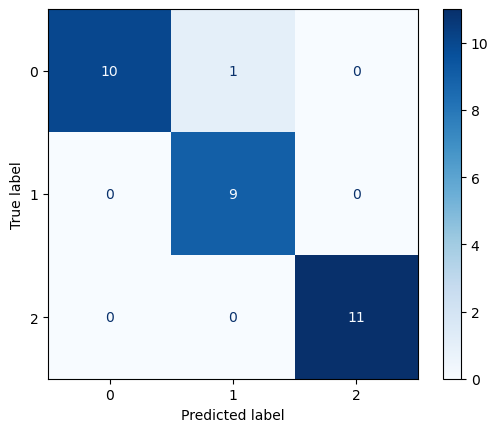

In [47]:
ConfusionMatrixDisplay.from_estimator(estimator=logr, X=X_test, y=y_test, cmap='Blues')

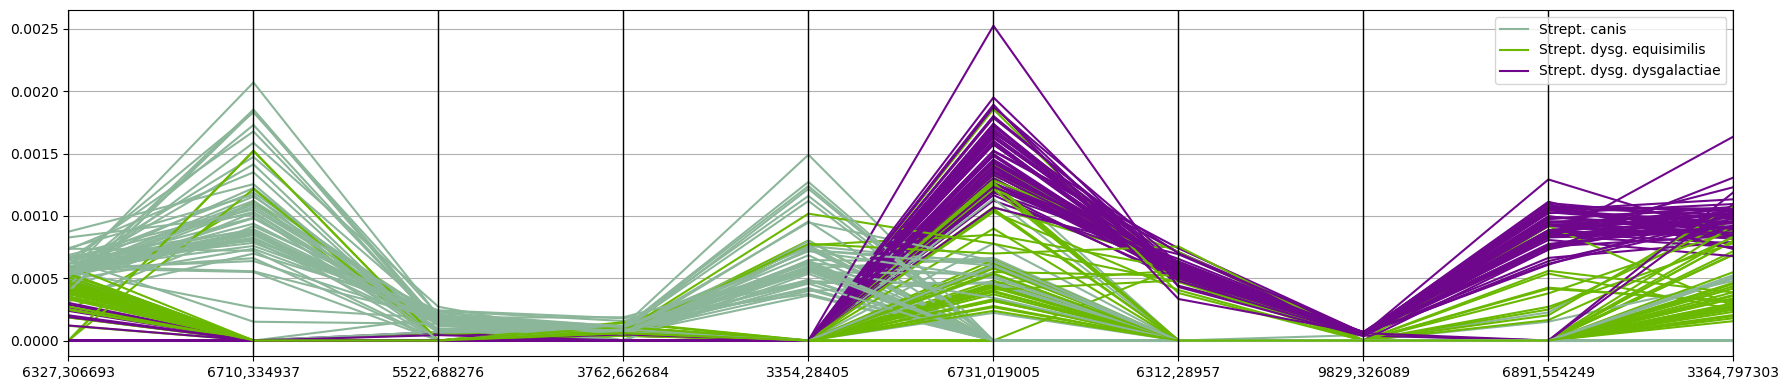

In [48]:
fig = plt.figure(figsize=(18, 4))
ax = fig.subplots()
parallel_coordinates(boxplot, class_column="target", ax=ax)
plt.tight_layout()
fig.show()

#### Decision tree with 10 best corr

In [49]:
dtc = DecisionTreeClassifier(random_state=42)
dtc = dtc.fit(X=X_train, y=y_train)
dtc

DecisionTreeClassifier(random_state=42)

In [50]:
dtc.get_depth()

4

In [51]:
feature_importances = dtc.feature_importances_
feature_importances

array([0.        , 0.08926059, 0.        , 0.49028939, 0.02372685,
       0.02394796, 0.34974416, 0.02303105, 0.        , 0.        ])

In [52]:
feature_index = X.columns
feature_index

Index(['6731,019005', '6312,28957', '9829,326089', '6891,554249',
       '3364,797303', '6327,306693', '6710,334937', '5522,688276',
       '3762,662684', '3354,28405'],
      dtype='object')

In [53]:
myDict = dict(zip(feature_index, feature_importances))

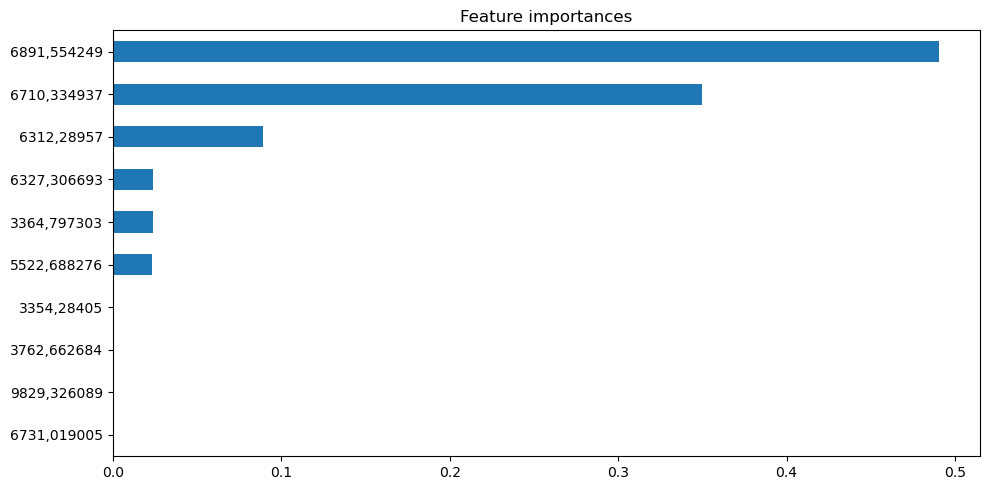

In [54]:
series = pd.Series(data=myDict.values(), index=myDict.keys()).sort_values()
series.plot(kind="barh", figsize=(10, 5), title=f"Feature importances", legend=None)
plt.tight_layout()
plt.show()

In [55]:
y_pred = dtc.predict(X=X_test)

In [56]:
accuracy_albero10 = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy of decision tree classifier on test set: {:.3f}'.format(accuracy_albero10))

Accuracy of decision tree classifier on test set: 0.968


In [57]:
y_pred_train = dtc.predict(X=X_train)
accuracy_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print(f"train accuracy score: {accuracy_train:.4f}")

train accuracy score: 1.0000


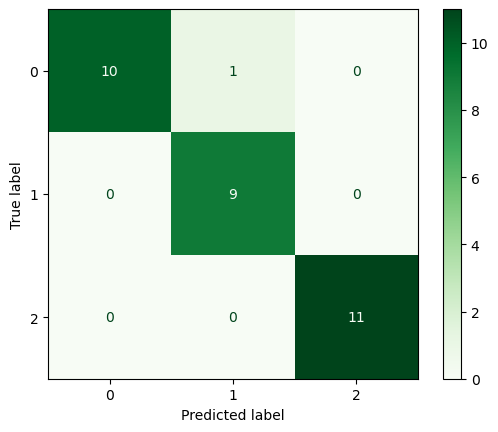

In [58]:
ConfusionMatrixDisplay.from_estimator(estimator=dtc, X=X_test, y=y_test, cmap='Greens')

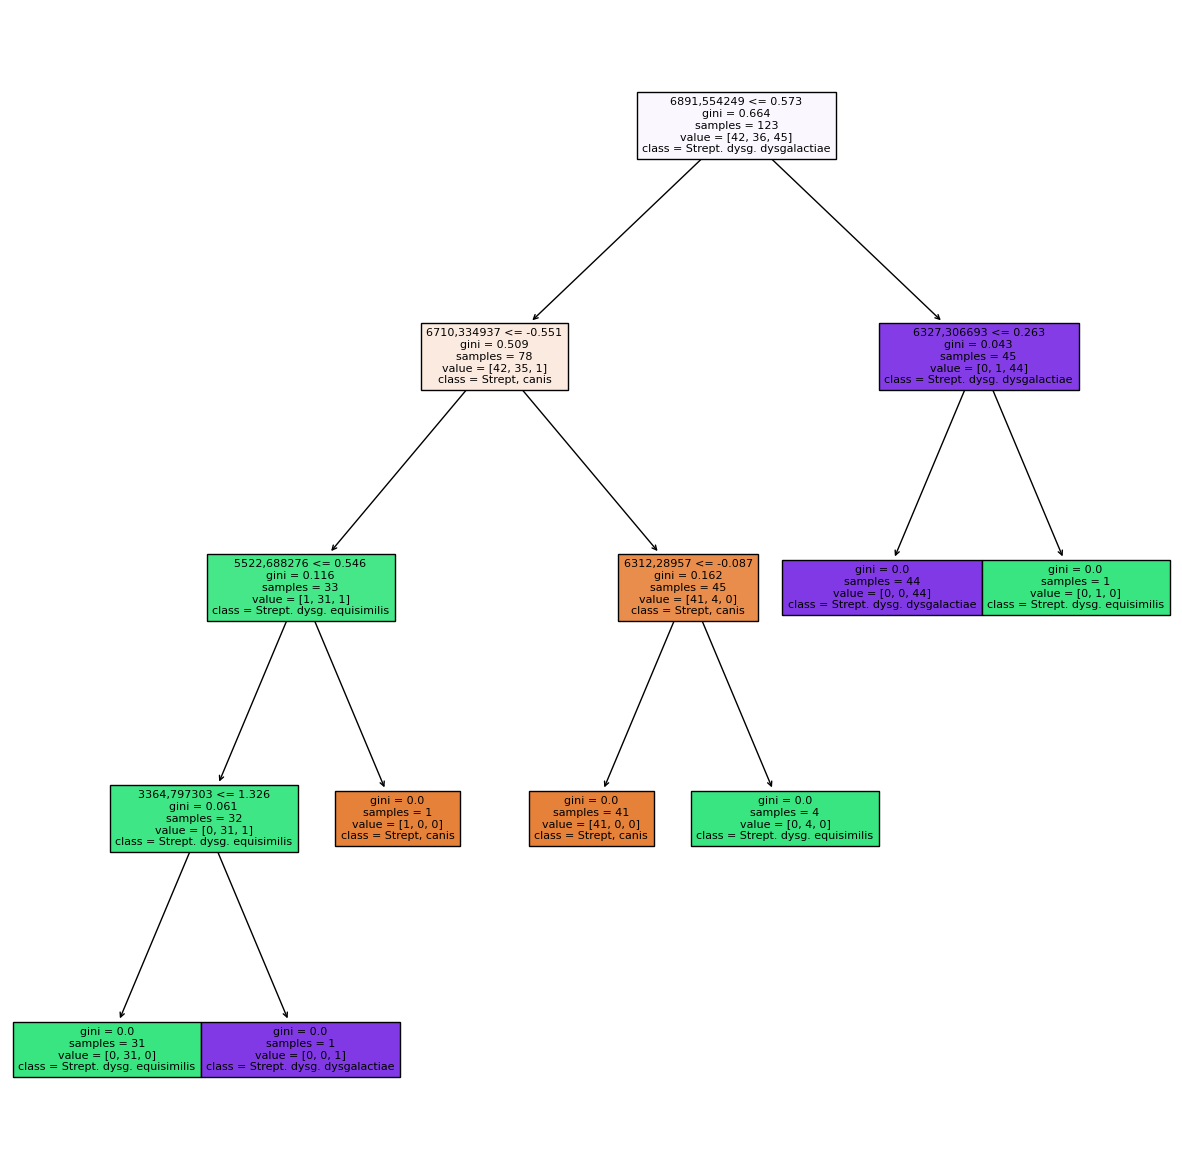

In [59]:
feature_names = feature_index
class_names = ["Strept, canis","Strept. dysg. equisimilis", "Strept. dysg. dysgalactiae"]

plt.figure(figsize=(15, 15))
plot_tree(decision_tree=dtc, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, fontsize=8)
plt.show()

#### K-nn with 10 best scorr

In [60]:
knn_scores = []

for k in range(1, X_train.shape[0], 2):
    # model definition and training
    knn = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=k))
    ])
    knn.fit(X=X_train, y=y_train)
    # compute accuracy on test set
    accuracy = knn.score(X_test, y_test)
    # store the results on a list of dictionaries
    metrics = {"# neighbors": k, "accuracy": accuracy}
    knn_scores.append(metrics)

# convert the list of dictionaries to pandas dataframe
df_knn_scores = pd.DataFrame(data=knn_scores)    #molto facile eveloce da dizionario a dataframe 
df_knn_scores

,# neighbors,accuracy
0,1,0.967742
1,3,0.967742
2,5,0.967742
3,7,0.967742
4,9,0.967742
...,...,...
56,113,0.677419
57,115,0.677419
58,117,0.677419
59,119,0.677419


In [61]:
mask = df_knn_scores["accuracy"] == df_knn_scores["accuracy"].max()   
df_knn_scores[mask]

,# neighbors,accuracy
0,1,0.967742
1,3,0.967742
2,5,0.967742
3,7,0.967742
4,9,0.967742
5,11,0.967742
6,13,0.967742


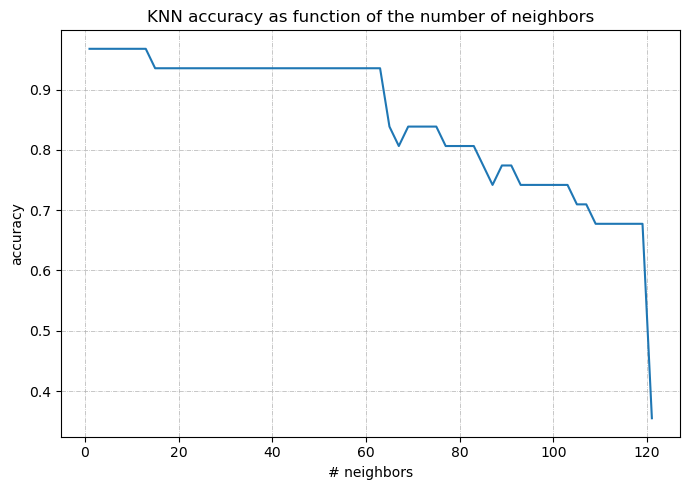

In [62]:
plt.figure(figsize=(7, 5))
plt.title("KNN accuracy as function of the number of neighbors")
sns.lineplot(x="# neighbors", y="accuracy", data=df_knn_scores)
plt.grid(linestyle='-.', linewidth=0.5)
plt.tight_layout()
plt.show()

In [63]:
knn_small = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=1))
])
knn_small.fit(X=X_train, y=y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=1))])

In [64]:
y_pred = knn_small.predict(X=X_test)

In [65]:
accuracy_knn10 = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy of k-nn classifier on test set with k=1: {:.3f}'.format(accuracy_knn10))

Accuracy of k-nn classifier on test set with k=1: 0.968


In [66]:
knn_big = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=37))
])
knn_big.fit(X=X_train, y=y_train)
y_pred = knn_big.predict(X=X_test)
accuracy_knn10_big = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy of k-nn classifier on test set with k=37: {:.3f}'.format(accuracy_knn10_big))

Accuracy of k-nn classifier on test set with k=37: 0.935


<font color= "red">Not work</font>

#### Random Forest with 10 best scorr

In [67]:
forest = RandomForestRegressor(n_estimators=200, 
                               max_features="sqrt", 
                               oob_score=True, 
                               random_state=42) # n_jobs=-1 per multithreading
forest.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=200, oob_score=True,
                      random_state=42)

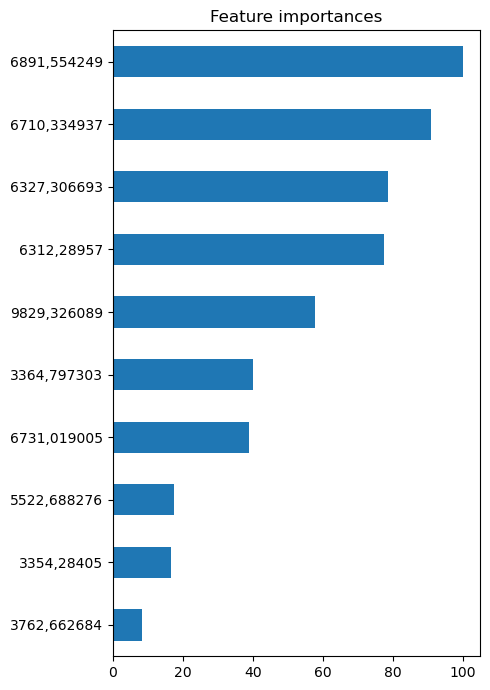

In [68]:
feature_importances_plot(model=forest, labels=X.columns)

In [69]:
forest.oob_score_

0.964885207618234

In [70]:
y_pred = forest.predict(X_test)

In [71]:
r2_rf10 = r2_score(y_test, y_pred)
print('R2 score of random forest classifier on test set: {:.3f}'.format(r2_rf10))

R2 score of random forest classifier on test set: 0.956


In [72]:
rmse_rf10 = mean_squared_error(y_test, y_pred, squared=False)
print('Mean squared error of random forest classifier on test set: {:.3f}'.format(rmse_rf10))

Mean squared error of random forest classifier on test set: 0.177


In [73]:
#regression_diagnostic_plot(y_test, y_pred)

TO DO:
- train con tutto dataset (maldi)
- Pca / feature selection
- dataset con 46 colonne maldi
- modello con multitarget (sensibilità agli antibiotici)

### Training con tutte le colonne maldi

In [74]:
y = maldi['target']
X = maldi.drop(columns='target')

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [76]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(123, 304)
(123,)
(31, 304)
(31,)


In [77]:
#Scaling dati
ss = StandardScaler()

In [78]:
X_train = ss.fit_transform(X=X_train)
X_test = ss.transform(X=X_test)

#### Logistic regression with all maldi

In [79]:
logr = LogisticRegression()
logr.fit(X=X_train,y=y_train)

LogisticRegression()

In [80]:
y_pred = logr.predict(X_test)
y_pred

array([2, 1, 2, 0, 2, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0, 2, 2, 0, 2, 2,
       1, 2, 2, 1, 0, 1, 2, 1, 0])

In [81]:
accuracy_logic = logr.score(X_test, y_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(accuracy_logic))

Accuracy of logistic regression classifier on test set: 0.774


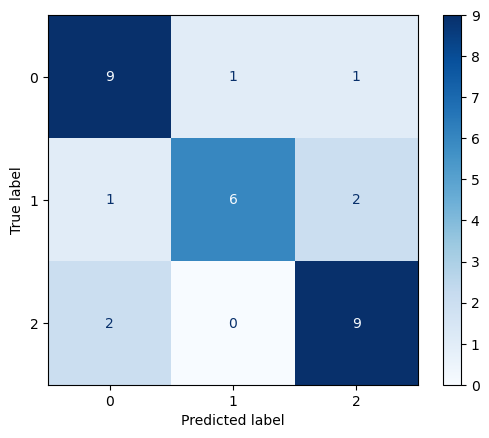

In [82]:
ConfusionMatrixDisplay.from_estimator(estimator=logr, X=X_test, y=y_test, cmap='Blues')

#### Decision tree with all maldi

In [83]:
dtc = DecisionTreeClassifier(random_state=42)
dtc = dtc.fit(X=X_train, y=y_train)
dtc

DecisionTreeClassifier(random_state=42)

In [84]:
dtc.get_depth()

4

In [86]:
feature_importances = dtc.feature_importances_
feature_index = X.columns
myDict = dict(zip(feature_index, feature_importances))

Index(['2057,143278', '2064,798679', '2071,138797', '2085,647901',
       '2103,986922', '2117,879078', '2129,309534', '2143,905333',
       '2173,98153', '2188,116404',
       ...
       '13617,65054', '14104,26499', '14945,23828', '15048,68998',
       '15154,39575', '15353,52046', '15399,07159', '15495,16655',
       '16076,29338', '16202,09535'],
      dtype='object', length=304)

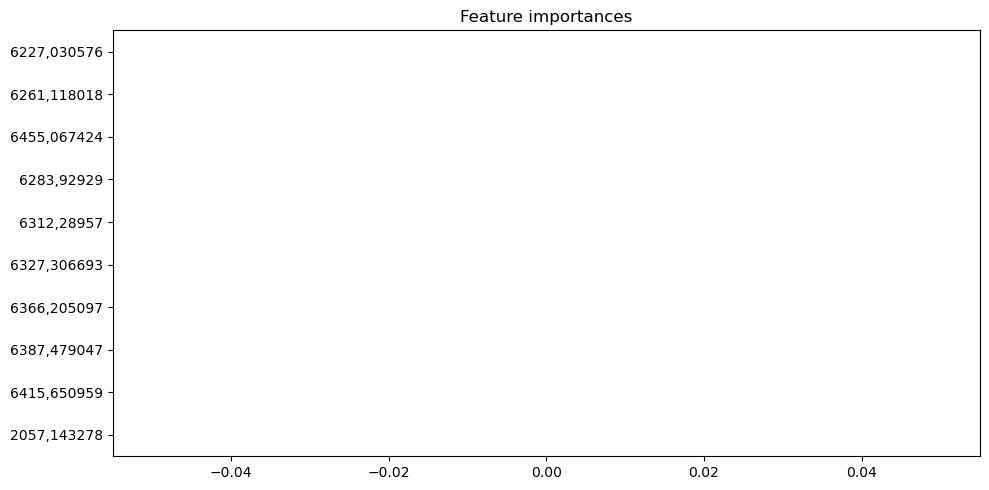

In [88]:
series = pd.Series(data=myDict.values(), index=myDict.keys()).sort_values().head(10)
print(series)
series.plot(kind="barh", figsize=(10, 5), title=f"Feature importances", legend=None)
plt.tight_layout()
plt.show()

In [89]:
y_pred = dtc.predict(X=X_test)

In [90]:
accuracy_albero = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy of decision tree classifier on test set: {:.3f}'.format(accuracy_albero))

Accuracy of decision tree classifier on test set: 0.968


In [91]:
y_pred_train = dtc.predict(X=X_train)
accuracy_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print(f"train accuracy score: {accuracy_train:.4f}")

train accuracy score: 1.0000


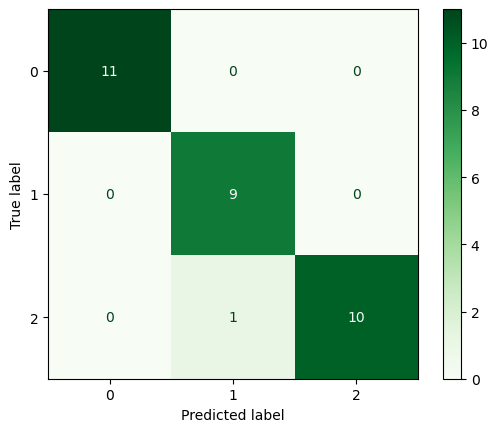

In [92]:
ConfusionMatrixDisplay.from_estimator(estimator=dtc, X=X_test, y=y_test, cmap='Greens')

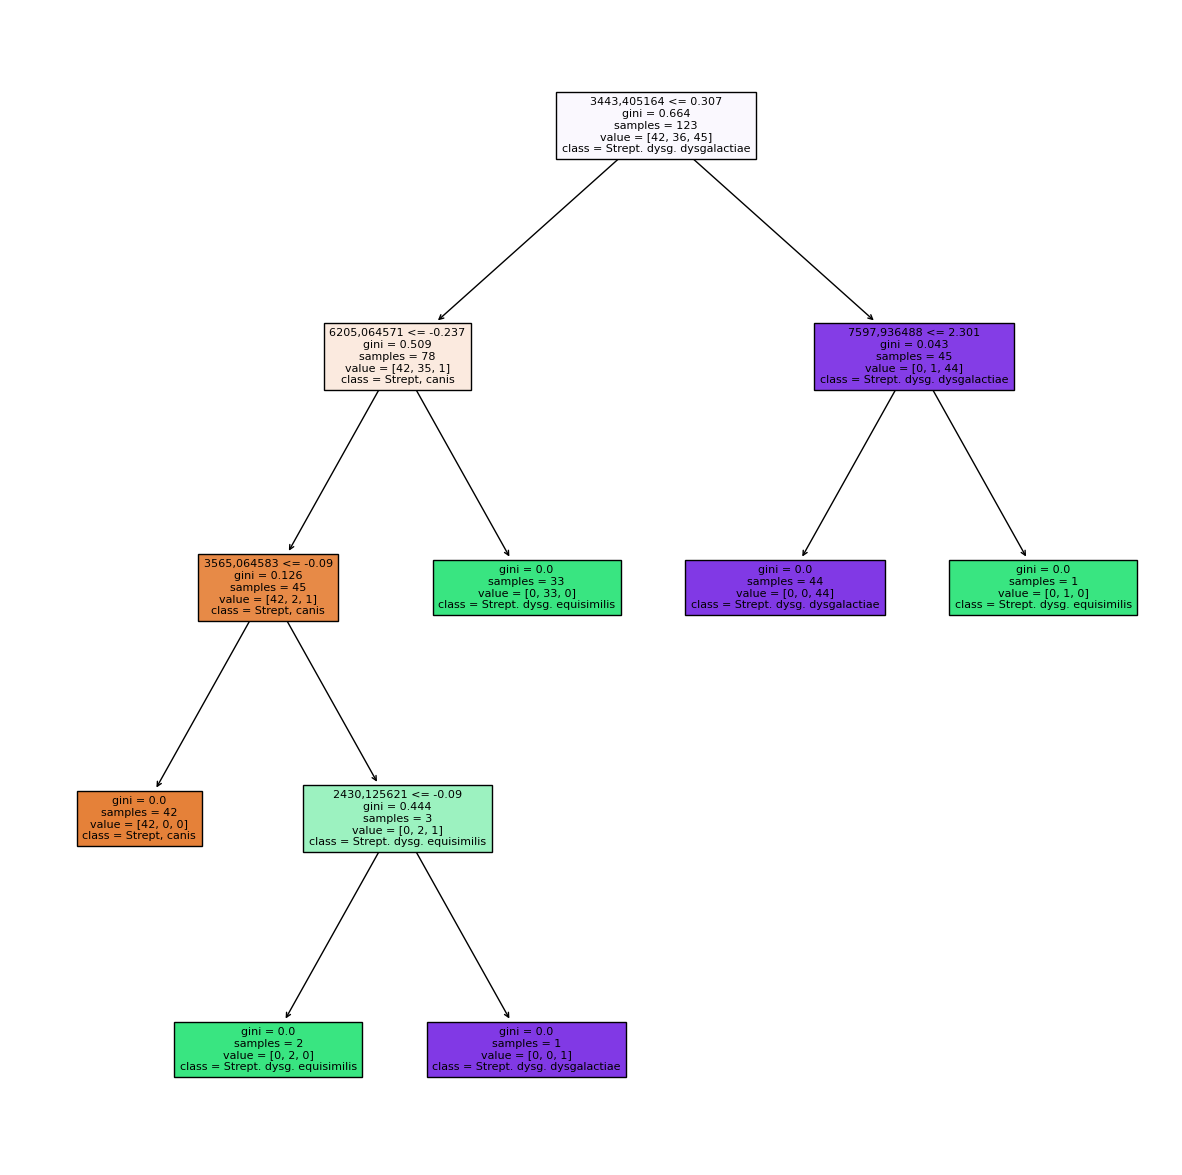

In [93]:
feature_names = feature_index
class_names = ["Strept, canis","Strept. dysg. equisimilis", "Strept. dysg. dysgalactiae"]

plt.figure(figsize=(15, 15))
plot_tree(decision_tree=dtc, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, fontsize=8)
plt.show()

#### K-nn with all maldi

In [94]:
knn_scores = []

for k in range(1, X_train.shape[0], 2):
    # model definition and training
    knn = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=k))
    ])
    knn.fit(X=X_train, y=y_train)
    # compute accuracy on test set
    accuracy = knn.score(X_test, y_test)
    # store the results on a list of dictionaries
    metrics = {"# neighbors": k, "accuracy": accuracy}
    knn_scores.append(metrics)

# convert the list of dictionaries to pandas dataframe
df_knn_scores = pd.DataFrame(data=knn_scores)    #molto facile eveloce da dizionario a dataframe 
df_knn_scores

,# neighbors,accuracy
0,1,0.741935
1,3,0.774194
2,5,0.774194
3,7,0.741935
4,9,0.806452
...,...,...
56,113,0.451613
57,115,0.419355
58,117,0.354839
59,119,0.354839


In [95]:
mask = df_knn_scores["accuracy"] == df_knn_scores["accuracy"].max()   
df_knn_scores[mask]

,# neighbors,accuracy
30,61,0.870968
31,63,0.870968
32,65,0.870968
33,67,0.870968


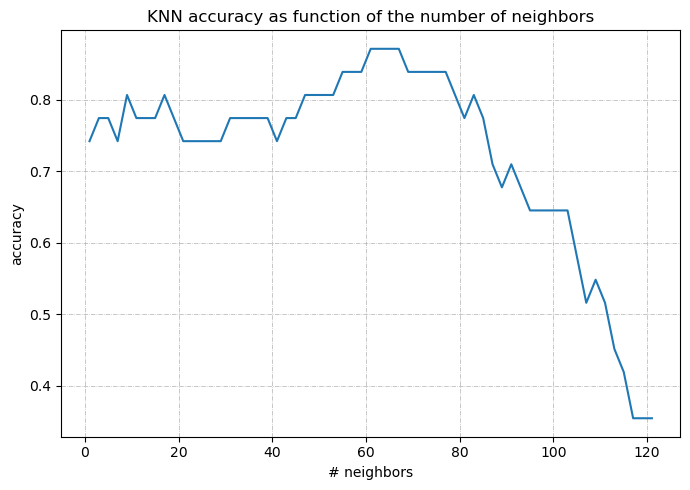

In [96]:
plt.figure(figsize=(7, 5))
plt.title("KNN accuracy as function of the number of neighbors")
sns.lineplot(x="# neighbors", y="accuracy", data=df_knn_scores)
plt.grid(linestyle='-.', linewidth=0.5)
plt.tight_layout()
plt.show()

In [97]:
knn_small = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=1))
])
knn_small.fit(X=X_train, y=y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=1))])

In [98]:
y_pred = knn_small.predict(X=X_test)

In [99]:
accuracy_knn = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy of k-nn classifier on test set with k=1: {:.3f}'.format(accuracy_knn))

Accuracy of k-nn classifier on test set with k=1: 0.742


In [100]:
knn_big = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=37))
])
knn_big.fit(X=X_train, y=y_train)
y_pred = knn_big.predict(X=X_test)
accuracy_knn_big = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy of k-nn classifier on test set with k=37: {:.3f}'.format(accuracy_knn_big))

Accuracy of k-nn classifier on test set with k=37: 0.774


#### Random Forest with all maldi

In [101]:
forest = RandomForestRegressor(n_estimators=200, 
                               max_features="sqrt", 
                               oob_score=True, 
                               random_state=42) # n_jobs=-1 per multithreading
forest.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=200, oob_score=True,
                      random_state=42)

<font color= "red">Come mostro solo le prime 10?</font>

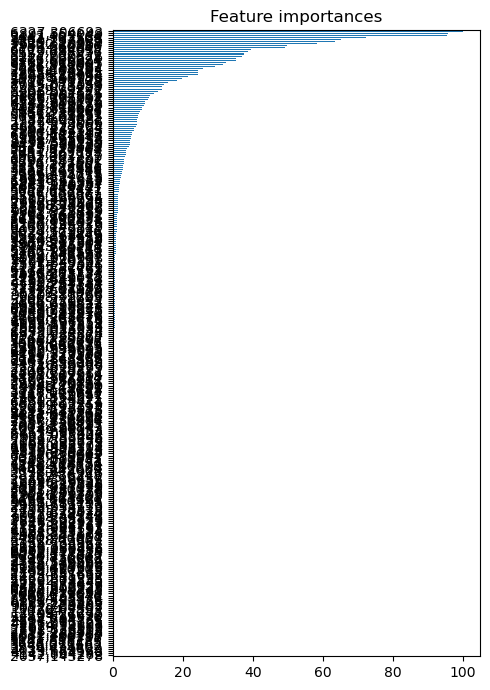

In [102]:
feature_importances_plot(model=forest, labels=X.columns)

In [103]:
forest.oob_score_

0.9730077810432438

In [104]:
y_pred = forest.predict(X_test)

In [105]:
r2_rf = r2_score(y_test, y_pred)
print('R2 score of random forest classifier on test set: {:.3f}'.format(r2_rf))

R2 score of random forest classifier on test set: 0.977


In [106]:
rmse_rf = mean_squared_error(y_test, y_pred, squared=False)
print('R2 score of random forest classifier on test set: {:.3f}'.format(rmse_rf))

R2 score of random forest classifier on test set: 0.126


### Training con dimensionality reduction (PCA)

In [114]:
y = maldi['target']
X = maldi.drop(columns='target')

In [115]:
#Scaling dati
ss = StandardScaler()

In [116]:
X_std = ss.fit_transform(X=X)
pca = PCA(n_components=None)
pca.fit(X_std)

NameError: name 'PCA' is not defined

In [117]:
pca.n_components_

NameError: name 'pca' is not defined

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [76]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(123, 304)
(123,)
(31, 304)
(31,)


In [78]:
X_train = ss.fit_transform(X=X_train)
X_test = ss.transform(X=X_test)

#### Logistic regression with all maldi

In [79]:
logr = LogisticRegression()
logr.fit(X=X_train,y=y_train)

LogisticRegression()

In [80]:
y_pred = logr.predict(X_test)
y_pred

array([2, 1, 2, 0, 2, 1, 0, 0, 0, 0, 2, 0, 1, 0, 0, 2, 0, 2, 2, 0, 2, 2,
       1, 2, 2, 1, 0, 1, 2, 1, 0])

In [81]:
accuracy_logic = logr.score(X_test, y_test)
print('Accuracy of logistic regression classifier on test set: {:.3f}'.format(accuracy_logic))

Accuracy of logistic regression classifier on test set: 0.774


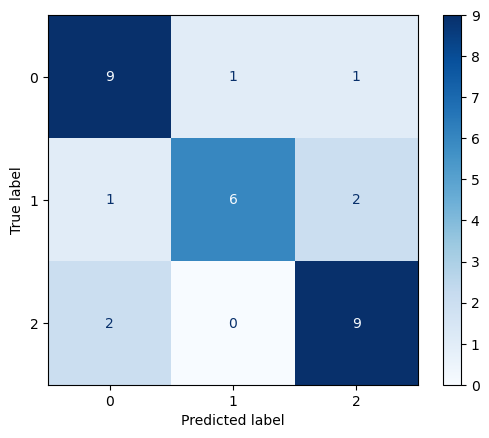

In [82]:
ConfusionMatrixDisplay.from_estimator(estimator=logr, X=X_test, y=y_test, cmap='Blues')

#### Decision tree with all maldi

In [83]:
dtc = DecisionTreeClassifier(random_state=42)
dtc = dtc.fit(X=X_train, y=y_train)
dtc

DecisionTreeClassifier(random_state=42)

In [84]:
dtc.get_depth()

4

In [86]:
feature_importances = dtc.feature_importances_
feature_index = X.columns
myDict = dict(zip(feature_index, feature_importances))

Index(['2057,143278', '2064,798679', '2071,138797', '2085,647901',
       '2103,986922', '2117,879078', '2129,309534', '2143,905333',
       '2173,98153', '2188,116404',
       ...
       '13617,65054', '14104,26499', '14945,23828', '15048,68998',
       '15154,39575', '15353,52046', '15399,07159', '15495,16655',
       '16076,29338', '16202,09535'],
      dtype='object', length=304)

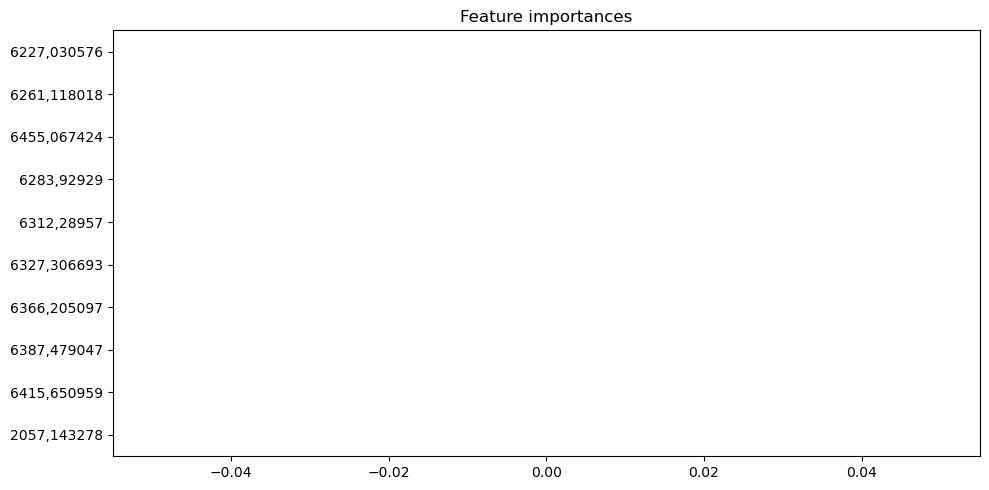

In [88]:
series = pd.Series(data=myDict.values(), index=myDict.keys()).sort_values().head(10)
print(series)
series.plot(kind="barh", figsize=(10, 5), title=f"Feature importances", legend=None)
plt.tight_layout()
plt.show()

In [89]:
y_pred = dtc.predict(X=X_test)

In [90]:
accuracy_albero = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy of decision tree classifier on test set: {:.3f}'.format(accuracy_albero))

Accuracy of decision tree classifier on test set: 0.968


In [91]:
y_pred_train = dtc.predict(X=X_train)
accuracy_train = accuracy_score(y_true=y_train, y_pred=y_pred_train)
print(f"train accuracy score: {accuracy_train:.4f}")

train accuracy score: 1.0000


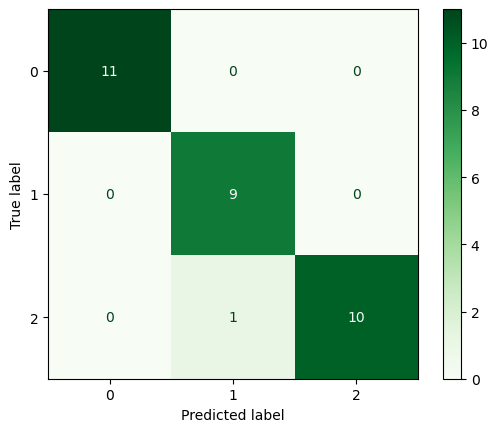

In [92]:
ConfusionMatrixDisplay.from_estimator(estimator=dtc, X=X_test, y=y_test, cmap='Greens')

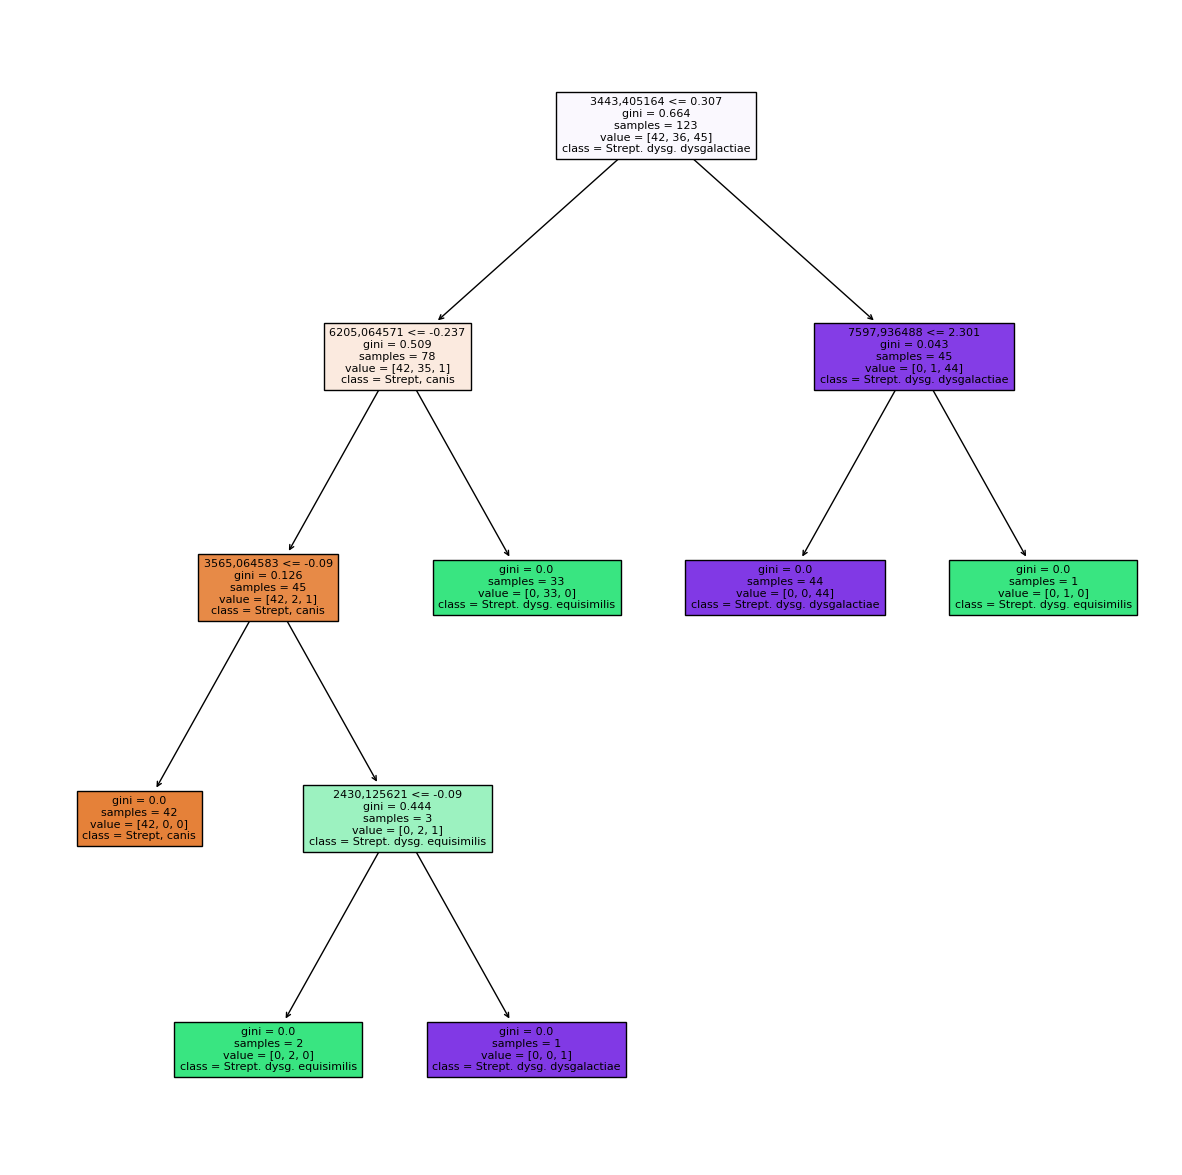

In [93]:
feature_names = feature_index
class_names = ["Strept, canis","Strept. dysg. equisimilis", "Strept. dysg. dysgalactiae"]

plt.figure(figsize=(15, 15))
plot_tree(decision_tree=dtc, 
          feature_names=feature_names, 
          class_names=class_names, 
          filled=True, fontsize=8)
plt.show()

#### K-nn with all maldi

In [94]:
knn_scores = []

for k in range(1, X_train.shape[0], 2):
    # model definition and training
    knn = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=k))
    ])
    knn.fit(X=X_train, y=y_train)
    # compute accuracy on test set
    accuracy = knn.score(X_test, y_test)
    # store the results on a list of dictionaries
    metrics = {"# neighbors": k, "accuracy": accuracy}
    knn_scores.append(metrics)

# convert the list of dictionaries to pandas dataframe
df_knn_scores = pd.DataFrame(data=knn_scores)    #molto facile eveloce da dizionario a dataframe 
df_knn_scores

,# neighbors,accuracy
0,1,0.741935
1,3,0.774194
2,5,0.774194
3,7,0.741935
4,9,0.806452
...,...,...
56,113,0.451613
57,115,0.419355
58,117,0.354839
59,119,0.354839


In [95]:
mask = df_knn_scores["accuracy"] == df_knn_scores["accuracy"].max()   
df_knn_scores[mask]

,# neighbors,accuracy
30,61,0.870968
31,63,0.870968
32,65,0.870968
33,67,0.870968


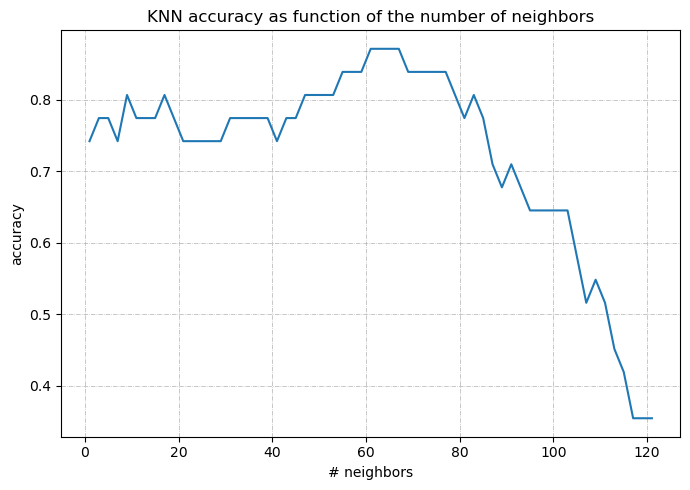

In [96]:
plt.figure(figsize=(7, 5))
plt.title("KNN accuracy as function of the number of neighbors")
sns.lineplot(x="# neighbors", y="accuracy", data=df_knn_scores)
plt.grid(linestyle='-.', linewidth=0.5)
plt.tight_layout()
plt.show()

In [97]:
knn_small = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=1))
])
knn_small.fit(X=X_train, y=y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', KNeighborsClassifier(n_neighbors=1))])

In [98]:
y_pred = knn_small.predict(X=X_test)

In [99]:
accuracy_knn = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy of k-nn classifier on test set with k=1: {:.3f}'.format(accuracy_knn))

Accuracy of k-nn classifier on test set with k=1: 0.742


In [100]:
knn_big = Pipeline(steps=[
    ("scaler", StandardScaler()),
    ("model", KNeighborsClassifier(n_neighbors=37))
])
knn_big.fit(X=X_train, y=y_train)
y_pred = knn_big.predict(X=X_test)
accuracy_knn_big = accuracy_score(y_true=y_test, y_pred=y_pred)
print('Accuracy of k-nn classifier on test set with k=37: {:.3f}'.format(accuracy_knn_big))

Accuracy of k-nn classifier on test set with k=37: 0.774


#### Random Forest with all maldi

In [101]:
forest = RandomForestRegressor(n_estimators=200, 
                               max_features="sqrt", 
                               oob_score=True, 
                               random_state=42) # n_jobs=-1 per multithreading
forest.fit(X_train, y_train)

RandomForestRegressor(max_features='sqrt', n_estimators=200, oob_score=True,
                      random_state=42)

<font color= "red">Come mostro solo le prime 10?</font>

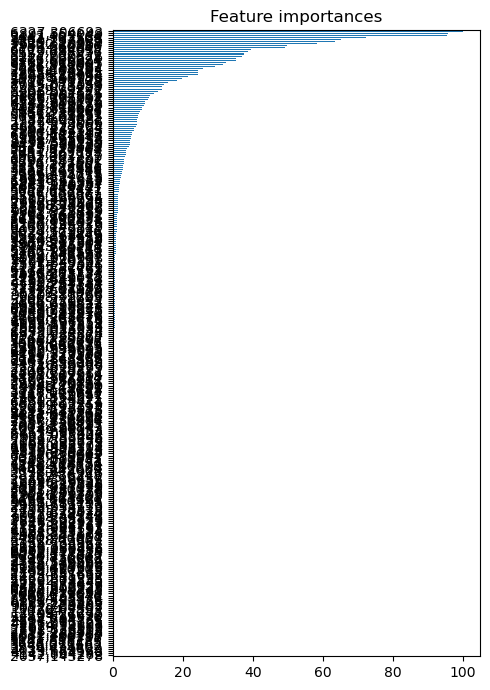

In [102]:
feature_importances_plot(model=forest, labels=X.columns)

In [103]:
forest.oob_score_

0.9730077810432438

In [104]:
y_pred = forest.predict(X_test)

In [105]:
r2_rf = r2_score(y_test, y_pred)
print('R2 score of random forest classifier on test set: {:.3f}'.format(r2_rf))

R2 score of random forest classifier on test set: 0.977


In [106]:
rmse_rf = mean_squared_error(y_test, y_pred, squared=False)
print('R2 score of random forest classifier on test set: {:.3f}'.format(rmse_rf))

R2 score of random forest classifier on test set: 0.126


# Antibiotici

In [107]:
antibiotici

,Ceftiofur,Tetraciclina,Gentamicina,Penicillina,Ampicillina,Sulfametossazolo_trimethoprim,Clindamicina,Enrofloxacin,aad(6),ANT(6)-Ia,...,optrA,poxtA,SAT-4,tet(40),tet(L),tetM,tetO,tetS,tetT,vatE
ID Strain,,,,,,,,,,,,,,,,,,,,,
V13,S,NS,NS,S,S,S,S,NS,0,0,...,0,0,0,0,0,0,0,0,0,0
V142,S,S,S,S,S,S,S,NS,0,0,...,0,0,0,0,0,0,0,0,0,0
V151,S,S,NS,S,S,S,S,NS,0,0,...,0,0,0,0,0,0,0,0,0,0
V160,S,NS,NS,S,S,S,S,NS,0,0,...,0,0,0,0,0,0,0,1,0,0
V161,S,S,NS,S,S,S,S,NS,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,S,NS,S,S,S,S,S,NS,0,0,...,0,0,0,0,0,1,0,0,0,0
V82,S,S,NS,S,S,S,S,S,0,0,...,0,0,0,0,0,0,0,0,0,0
V90,S,NS,NS,S,S,S,S,NS,0,0,...,0,0,0,0,0,0,0,0,0,0


In [108]:
antibiotici.dtypes

Ceftiofur                                        object
Tetraciclina                                     object
Gentamicina                                      object
Penicillina                                      object
Ampicillina                                      object
Sulfametossazolo_trimethoprim                    object
Clindamicina                                     object
Enrofloxacin                                     object
aad(6)                                            int64
ANT(6)-Ia                                         int64
APH(2'')-IIIa                                     int64
APH(3')-IIIa                                      int64
catS                                              int64
dfrF                                              int64
E. faecalis chloramphenicol acetyltransferase     int64
Erm(47)                                           int64
ErmB                                              int64
fexA                                            

In [109]:
i = 0
for column in antibiotici.columns:
    print(i, column, antibiotici[column].unique())
    i += 1

0 Ceftiofur ['S']
1 Tetraciclina ['NS' 'S']
2 Gentamicina ['NS' 'S']
3 Penicillina ['S']
4 Ampicillina ['S']
5 Sulfametossazolo_trimethoprim ['S' 'NS']
6 Clindamicina ['S' 'NS']
7 Enrofloxacin ['NS' 'S']
8 aad(6) [0 1]
9 ANT(6)-Ia [0 1]
10 APH(2'')-IIIa [0]
11 APH(3')-IIIa [0 1]
12 catS [0 1]
13 dfrF [0 1]
14 E. faecalis chloramphenicol acetyltransferase [0 1]
15 Erm(47) [0 1]
16 ErmB [0 1]
17 fexA [0 1]
18 L._reuteri cat-TC [0]
19 lmrP [1 0]
20 lnuC [0 1]
21 lnuD [0 1]
22 lsaC [0 1]
23 lsaE [0 1]
24 mefE [0 1]
25 optrA [0 1]
26 poxtA [0 1]
27 SAT-4 [0 1]
28 tet(40) [0 1]
29 tet(L) [0 1]
30 tetM [0 1]
31 tetO [0 1]
32 tetS [0 1]
33 tetT [0 1]
34 vatE [0 1]


Ceftiofur, Penicillina, Ampicillina   ['S'] --> 1 solo valore -> si possono eliminare
Tetraciclina, Gentamicina, Sulfametossazolo_trimethoprim, Clindamicina ['S' 'NS'] --> OneHotEncoder

In [110]:
antibiotici.drop(['Ceftiofur', 'Penicillina', 'Ampicillina'], axis=1, inplace=True)
antibiotici_X = ['Tetraciclina', 'Gentamicina', 'Sulfametossazolo_trimethoprim', 'Clindamicina','Enrofloxacin']
ct_ant = ColumnTransformer(transformers=[
    ("OneHot", OneHotEncoder(drop="first", sparse=False, dtype=int), antibiotici_X)
],remainder="passthrough")

antibiotici_arr = ct_ant.fit_transform(X=antibiotici[antibiotici_X])
antibiotici_enc = pd.DataFrame(data=antibiotici_arr, columns=ct_ant.get_feature_names_out())
antibiotici_enc

,OneHot__Tetraciclina_S,OneHot__Gentamicina_S,OneHot__Sulfametossazolo_trimethoprim_S,OneHot__Clindamicina_S,OneHot__Enrofloxacin_S
0,0,0,1,1,0
1,1,1,1,1,0
2,1,0,1,1,0
3,0,0,1,1,0
4,1,0,1,1,0
...,...,...,...,...,...
149,0,1,1,1,0
150,1,0,1,1,1
151,0,0,1,1,0
152,1,0,1,1,0


In [111]:
antibiotici[antibiotici_X] = antibiotici_enc.values
antibiotici

,Tetraciclina,Gentamicina,Sulfametossazolo_trimethoprim,Clindamicina,Enrofloxacin,aad(6),ANT(6)-Ia,APH(2'')-IIIa,APH(3')-IIIa,catS,...,optrA,poxtA,SAT-4,tet(40),tet(L),tetM,tetO,tetS,tetT,vatE
ID Strain,,,,,,,,,,,,,,,,,,,,,
V13,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
V142,1,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
V151,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
V160,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
V161,1,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,0,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
V82,1,0,1,1,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
V90,0,0,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Geni Antibiotico

In [112]:
geni_antibiotico

,gbs0630,gbs0631,gbs0632,hasC,lmb,mf2,mf3,scpA,sda,ska,slo,smeZ,spec,speg,spek,spel,spem
ID Strain,,,,,,,,,,,,,,,,,
V13,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
V142,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
V151,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
V160,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
V161,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V800,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0
V82,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
V90,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0


In [113]:
geni_antibiotico.dtypes

gbs0630    int64
gbs0631    int64
gbs0632    int64
hasC       int64
lmb        int64
mf2        int64
mf3        int64
scpA       int64
sda        int64
ska        int64
slo        int64
smeZ       int64
spec       int64
speg       int64
spek       int64
spel       int64
spem       int64
dtype: object